<a href="https://colab.research.google.com/github/Katrin-Leberfinger/Hybrid-gender-debiased-music-recommendation/blob/main/01_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

# Read Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Master\ Thesis/data

/content/drive/MyDrive/Master Thesis/data


In [5]:
data_tracks_lyrics = pd.read_csv("music/data_tracks_lyrics.txt", sep="\t").drop(['Unnamed: 0'],axis=1).dropna()
data_tracks_tags_lyrics = pd.read_csv("music/data_tracks_tags_lyrics.txt", sep="\t").drop(['Unnamed: 0'],axis=1).dropna().drop_duplicates('track_id')
data_bio = pd.read_csv("music/data_artists_biography.txt", sep=",").drop(['Unnamed: 0'],axis=1).dropna()
data_interaction = pd.read_csv("music/data_user_track_interaction.txt", sep="\t").drop(['Unnamed: 0'],axis=1)

data_tracks_tags_lyrics = data_tracks_tags_lyrics.merge(data_bio)
data_interaction = data_interaction.merge(data_tracks_tags_lyrics[['track_id']].drop_duplicates(), on = 'track_id', how = 'inner').drop_duplicates()
data_tracks_tags_lyrics = data_tracks_tags_lyrics.merge(data_interaction[['track_id']], on = 'track_id', how = 'inner').drop_duplicates()

data_user = pd.read_csv("music/data_user.txt", sep="\t").drop(['Unnamed: 0'],axis=1)

In [6]:
# data_movies = pd.read_csv("movies/movies_abstracts.csv").drop(['Unnamed: 0'],axis=1).dropna()
# data_interaction = pd.read_csv("movies/ratings.csv").drop(['timestamp'],axis=1)

# data_movies = pd.merge(data_movies, data_interaction[['movieId']], 'inner').drop_duplicates()
# data_interaction = pd.merge(data_interaction, data_movies[['movieId']], 'inner')

# data_movies.columns = ['track_id', 'lyrics_cleaned', 'tags', 'abstract']
# data_tracks_tags_lyrics = data_movies

# data_interaction.columns = ['user_id', 'track_id', 'count']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


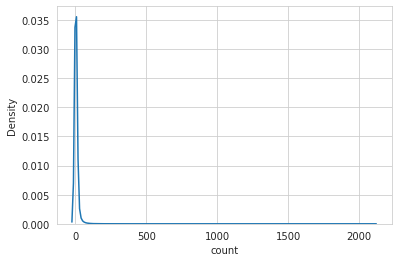

In [7]:
import seaborn as sns
sns.set_style('whitegrid')
sns.kdeplot(data_interaction['count'], bw=0.5)

In [8]:
data_interaction

,user_id,track_id,count
0,11095,6258001,2
1,22431,6258001,6
2,84649,6258001,2
3,40037,6258001,8
4,41988,6258001,14
...,...,...,...
431872,7733,6693897,3
431873,90271,33362113,3
431874,14333,3164587,2
431875,14333,33751823,2


In [9]:
# filter out playcount 1
data_interaction = data_interaction[data_interaction['count'] != 1]

In [10]:
# data_interaction.loc[data_interaction['count']<4., 'count'] = 0.
# data_interaction.loc[data_interaction['count']>=4., 'count'] = 1.

In [11]:
data_interaction

,user_id,track_id,count
0,11095,6258001,2
1,22431,6258001,6
2,84649,6258001,2
3,40037,6258001,8
4,41988,6258001,14
...,...,...,...
431872,7733,6693897,3
431873,90271,33362113,3
431874,14333,3164587,2
431875,14333,33751823,2


In [12]:
# filter out users with too little playcount
df_per_users = data_interaction.groupby(['user_id']).size().reset_index(name='counts')
users = df_per_users[df_per_users['counts'] >= 25]['user_id'].values
data_interaction = data_interaction[data_interaction['user_id'].isin(users)]

In [13]:
# filter out tracks with too little playcount
df_per_track = data_interaction.groupby(['track_id']).size().reset_index(name='counts')
tracks = df_per_track[df_per_track['counts'] >= 25]['track_id'].values
data_interaction = data_interaction[data_interaction['track_id'].isin(tracks)]

In [14]:
data_interaction_plot = data_interaction.copy()

In [15]:
data_interaction.loc[data_interaction['count']>=2., 'count'] = 1.

## CV and balance data set

In [18]:
# add negative samples
import random
random.seed(123)
data_interaction_new = pd.DataFrame(columns = data_interaction.columns)
for user_id,df in data_interaction.groupby('user_id'):
  n_diff = len(df[df['count'] >= 1]) - len(df[df['count'] == 0])
  if n_diff > 1:
    df_tmp = df.merge(data_interaction[['track_id']], how = 'right')
    neg_list = random.sample(list(df_tmp[np.isnan(df_tmp.user_id)].track_id.values), n_diff)
    df_neg = pd.DataFrame({'user_id': user_id, 'track_id':neg_list, 'count':0})
    data_interaction_new=data_interaction_new.append(df)
    data_interaction_new=data_interaction_new.append(df_neg)
  else:
    data_interaction_new = data_interaction_new.append(df)

data_interaction_new = shuffle(data_interaction_new)

In [ ]:
# data_interaction_new = data_interaction
# data_interaction_new = shuffle(data_interaction_new)

In [19]:
data_interaction_new = data_interaction_new.merge(data_tracks_tags_lyrics[['track_id', 'lyrics_cleaned', 'tags', 'abstract']]).drop_duplicates()

In [20]:
data_tracks_tags_lyrics = data_tracks_tags_lyrics.merge(data_interaction_new[['track_id']]).drop_duplicates()

In [22]:
np.random.seed(123)
data_interaction_new['fold'] = np.random.randint(1, 6, data_interaction_new.shape[0])

In [33]:
test_fold = 1
val_fold = 2

data_interaction_train = data_interaction_new.loc[((data_interaction_new.fold != test_fold) & (data_interaction_new.fold != val_fold)), ['user_id', 'track_id', 'count', 'lyrics_cleaned', 'tags', 'abstract']]
data_interaction_test = data_interaction_new.loc[data_interaction_new.fold == test_fold, ['user_id', 'track_id', 'count', 'lyrics_cleaned', 'tags', 'abstract']]
data_interaction_val = data_interaction_new.loc[data_interaction_new.fold == val_fold,  ['user_id', 'track_id', 'count', 'lyrics_cleaned', 'tags', 'abstract']]

In [34]:
# itermin solution (maybe change later)
selected_user = []
data_interaction_test_new = pd.DataFrame()
for user_id,df in data_interaction_test.groupby('user_id'):
  if len(df[df['count'] > 0]) >= 10:
    df_tmp = df.merge(data_interaction_new[['track_id']].drop_duplicates(), how = 'right').drop_duplicates()
    items_to_ignore = data_interaction_train[(data_interaction_train['user_id'] == user_id) & (data_interaction_train['count'] > 0)]['track_id'].values
    df_tmp = df_tmp[~df_tmp['track_id'].isin(items_to_ignore)]
    neg_list = list(set(df_tmp.loc[df_tmp.isna().any(axis=1),].track_id.values))
    df_neg = pd.DataFrame({'user_id': user_id, 'track_id':neg_list, 'count':0})
    data_interaction_test_new=data_interaction_test_new.append(df_neg)
    data_interaction_test_new=data_interaction_test_new.append(df)
    selected_user.append(user_id)
    
  
data_interaction_test = data_interaction_test_new
data_interaction_test = data_interaction_test[['user_id', 'track_id', 'count']].merge(data_tracks_tags_lyrics[['track_id', 'lyrics_cleaned', 'tags', 'abstract']], on = 'track_id', how = 'left').drop_duplicates()
data_interaction_test = data_interaction_test.loc[(data_interaction_test.user_id.isin(selected_user))]
data_interaction_test = shuffle(data_interaction_test)

In [38]:
dir = "preprocessed_data_binary/"

In [39]:
data_interaction.to_csv(dir + 'data_interaction.csv', encoding = 'utf-8-sig') 
data_tracks_tags_lyrics.to_csv(dir + 'data_tracks_tags_lyrics.csv', encoding = 'utf-8-sig') 

data_interaction_test.to_csv(dir + 'data_interaction_test.csv', encoding = 'utf-8-sig') 
data_interaction_train.to_csv(dir + 'data_interaction_train.csv', encoding = 'utf-8-sig') 
data_interaction_val.to_csv(dir + 'data_interaction_val.csv', encoding = 'utf-8-sig') 

# Visualize data

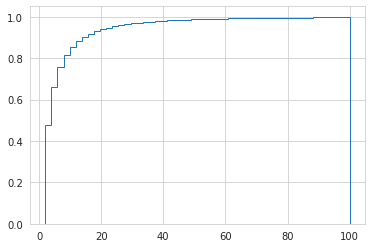

In [ ]:
data_interaction_plot.loc[data_interaction_plot['count']>=100., 'count'] = 100.
plt.hist(data_interaction_plot['count'], 50, density=True, histtype='step', cumulative=True)
plt.show()

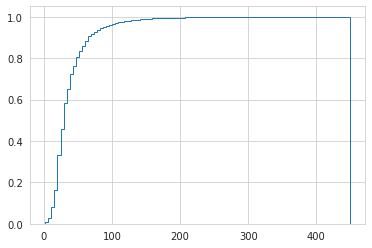

In [ ]:
data_interaction_plot_per_user = data_interaction.groupby(['user_id']).size().reset_index(name='counts')
plt.hist(data_interaction_plot_per_user['counts'], 100, density=True, histtype='step', cumulative=True)
plt.show()

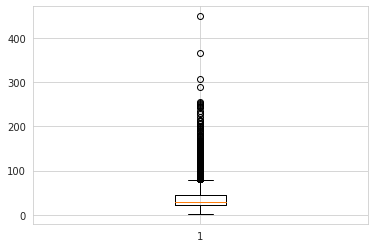

In [ ]:
plt.boxplot(data_interaction_plot_per_user['counts'])
plt.show()

In [ ]:
data_interaction_plot_per_user[['counts']].describe()

,counts
count,5486.000000
mean,38.479584
std,29.092783
min,2.000000
25%,22.000000
50%,30.000000
75%,45.000000
max,449.000000


# Data statistics

In [ ]:
# Unique numbers
print("Unique users: ", len(data_interaction.user_id.unique()))
print("Unique tracks: ", len(data_interaction.track_id.unique()))
print("Unique artists: ", len(data_tracks_tags_lyrics.track_artist.unique()))
print("Listening events: ", len(data_interaction))


Unique users:  5486
Unique tracks:  3214
Unique artists:  886
Listening events:  211099


In [ ]:
# User gender split
data_all_info = pd.read_csv("music/data_all_info.txt", sep="\t").drop(['Unnamed: 0'],axis=1)
data_user = pd.read_csv("music/data_user.txt", sep="\t").drop(['Unnamed: 0'],axis=1)
data_user.columns = ['user_id', 'gender_user']
data_interaction.merge(data_user)[['user_id', 'gender_user']].drop_duplicates()[['gender_user']].value_counts()

gender_user
m              4560
f               926
dtype: int64

In [ ]:
data_interaction.merge(data_user)[['user_id', 'gender_user']].drop_duplicates()[['gender_user']].value_counts() / len(data_interaction.user_id.unique())

gender_user
m              0.831207
f              0.168793
dtype: float64

In [ ]:
# Artist gender split
data_interaction.merge(data_all_info)[['track_artist', 'gender_artist']].drop_duplicates()[['gender_artist']].value_counts()

gender_artist
male             705
female           181
dtype: int64

In [ ]:
data_interaction.merge(data_all_info)[['track_artist', 'gender_artist']].drop_duplicates()[['gender_artist']].value_counts() / len(data_tracks_tags_lyrics.track_artist.unique())

gender_artist
male             0.795711
female           0.204289
dtype: float64

In [ ]:
# Artist gender split in listening events
data_interaction.merge(data_all_info)[['gender_artist']].value_counts()


gender_artist
male             184864
female            34036
dtype: int64

In [ ]:
data_interaction.merge(data_all_info)[['gender_artist']].value_counts() / len(data_interaction)

gender_artist
male             0.861090
female           0.182586
dtype: float64

In [ ]:
# User gender vs artist gender in listening events
df = data_interaction.merge(data_all_info).merge(data_user)
df.gender_artist.groupby([df.gender_user, df.gender_artist]).count()

gender_user  gender_artist
f            female             7632
             male              22556
m            female            26404
             male             162308
Name: gender_artist, dtype: int64

In [ ]:
df[['gender_user']].value_counts()

gender_user
m              188712
f               30188
dtype: int64

In [ ]:
df

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Number of listening events per user gender')

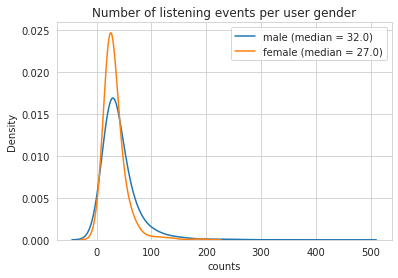

In [ ]:
# Plot: Distribution of listening events per artist gender (x-axis number of listening events, y-axis number of tracks, split up by gender)
df_female = df[df.gender_user == "f"]
df_female = df_female.groupby(['user_id']).size().reset_index(name='counts')
df_male = df[df.gender_user == "m"]
df_male = df_male.groupby(['user_id']).size().reset_index(name='counts')
sns.kdeplot(df_male['counts'], bw=0.5, label=f"male (median = {df_male['counts'].median()})")
sns.kdeplot(df_female['counts'], bw=0.5, label=f"female (median = {df_female['counts'].median()})")
plt.legend()
plt.title("Number of listening events per user gender")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Number of listening events per artist gender')

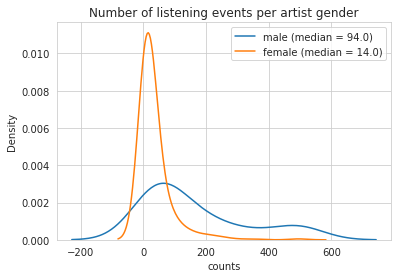

In [ ]:
df_female = df[df.gender_user == "f"]
df_female = df_female.groupby(['track_artist']).size().reset_index(name='counts')
df_female.loc[df_female['counts']>500, 'counts'] = 500
df_male = df[df.gender_user == "m"]
df_male = df_male.groupby(['track_artist']).size().reset_index(name='counts')
df_male.loc[df_male['counts']>500, 'counts'] = 500
sns.kdeplot(df_male['counts'], bw=0.5, label=f"male (median = {df_male['counts'].median()})")
sns.kdeplot(df_female['counts'], bw=0.5, label=f"female (median = {df_female['counts'].median()})")
plt.legend()
plt.title("Number of listening events per artist gender")